In [1]:
import os

from dvclive import Live
from dvclive.lightning import DVCLiveLogger
import numpy as np
import pytorch_lightning as pl
from torch import optim, nn, utils, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the LightningModule
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder_size):
        super().__init__()

        # Saves any args passed to __init__ (for example, encoder_size)
        self.save_hyperparameters()

        self.encoder = nn.Sequential(nn.Linear(28 * 28, encoder_size), nn.ReLU(), nn.Linear(encoder_size, 3))
        self.decoder = nn.Sequential(nn.Linear(3, encoder_size), nn.ReLU(), nn.Linear(encoder_size, 28 * 28))

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [3]:
# setup data
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())
train_loader = utils.data.DataLoader(dataset)

In [4]:
# train the model
autoencoder = LitAutoEncoder(encoder_size=128)
trainer = pl.Trainer(
    limit_train_batches=200,
    max_epochs=5,
    logger=DVCLiveLogger(save_dvc_exp=True)
)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/dave/Code/dvclive-exp-tracking/DvcLiveLogger/dvclive_run/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 100 K 
1 | decoder | Sequential | 101 K 
---------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.810     Total est

Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 60.27it/s, loss=0.0516, v_num=_run]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 60.16it/s, loss=0.0516, v_num=_run]


In [5]:
import pandas as pd
from dvc.api import exp_show

pd.DataFrame(exp_show())

,Experiment,rev,typ,Created,parent,State,Executor,train.loss,epoch,step,encoder_size
0,,workspace,baseline,None,,None,None,0.053965,4.0,999.0,128.0
1,,main,baseline,"Apr 28, 2023",,None,None,0.056488,4.0,999.0,64.0
2,gummy-lush,7877976,branch_commit,03:48 PM,,None,None,0.053965,4.0,999.0,128.0
3,cronk-yegg,23e91fb,branch_commit,03:45 PM,,None,None,0.054479,4.0,999.0,128.0
4,alive-ruin,6ac1f68,branch_commit,03:44 PM,,None,None,0.055447,4.0,999.0,128.0
5,riant-kind,d98160f,branch_commit,03:43 PM,,None,None,0.033732,2.0,449.0,128.0
6,broch-lien,3cd4960,branch_commit,03:28 PM,,None,None,0.053940,4.0,999.0,128.0
7,podgy-coho,d6cd672,branch_commit,03:25 PM,,None,None,0.055789,4.0,999.0,128.0
8,ebony-prob,5aaa52a,branch_commit,03:24 PM,,None,None,0.059099,4.0,999.0,128.0
9,picky-peel,bec8893,branch_commit,03:23 PM,,None,None,0.052576,4.0,999.0,128.0


# DVC Report

params.yaml

|   encoder_size |
|----------------|
|             32 |

metrics.json

| train                          |   epoch |   step |
|--------------------------------|---------|--------|
| {'loss': 0.056226570159196854} |       4 |    999 |

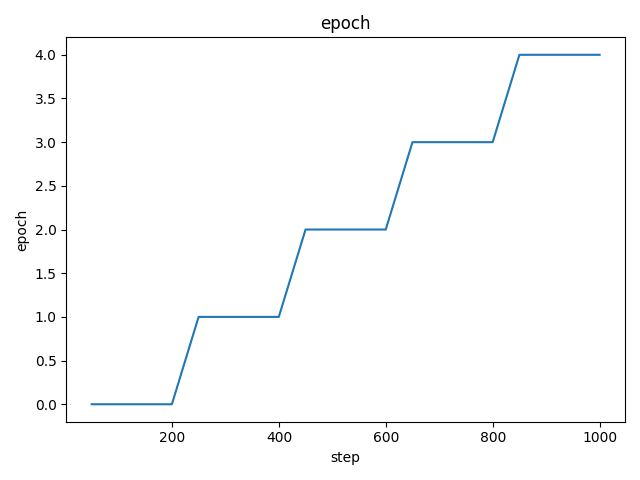

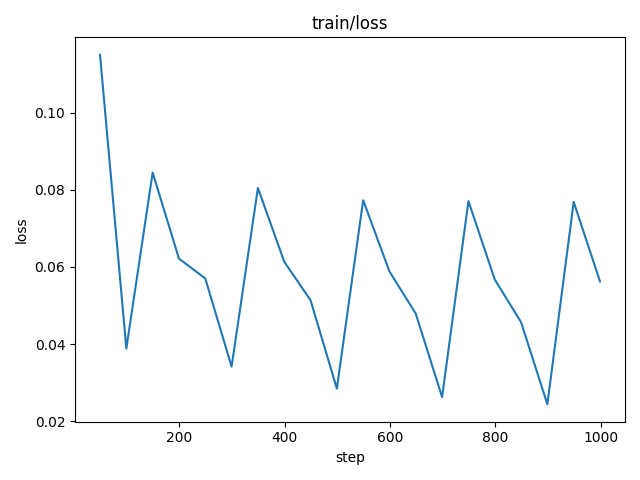

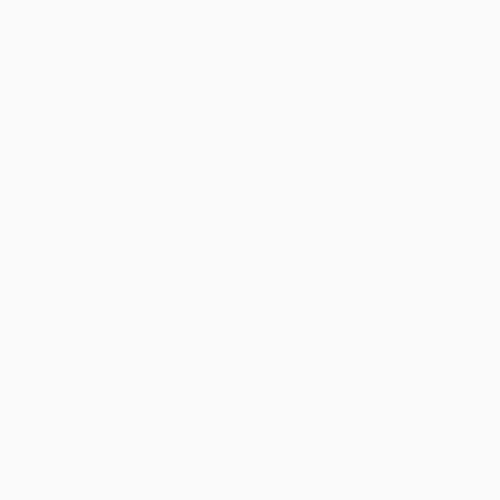


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/dave/miniforge3/envs/dvc/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/dave/Code/dvclive-exp-tracking/DvcLiveLogger/dvclive_run/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.2 K
1 | decoder | Sequential | 26.0 K
---------------------------------------
51.2 K    Trainable params
0         Non-trainable params
51.2 K    Total params
0.205     Total est

Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 55.56it/s, loss=0.0557, v_num=_run] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 55.29it/s, loss=0.0557, v_num=_run]



# DVC Report

params.yaml

|   encoder_size |
|----------------|
|             64 |

metrics.json

| train                         |   epoch |   step |
|-------------------------------|---------|--------|
| {'loss': 0.05538463965058327} |       4 |    999 |

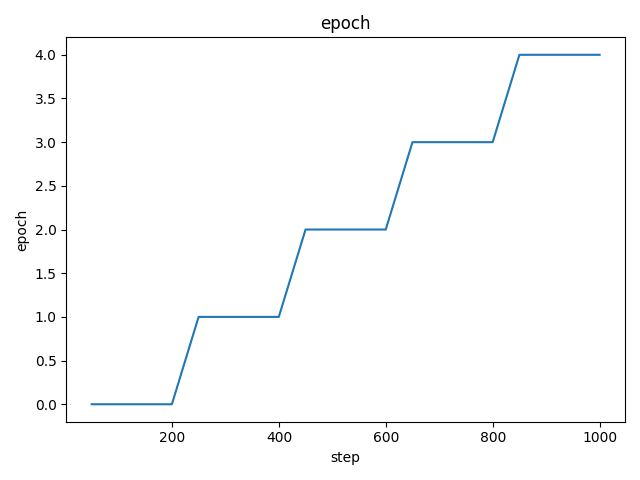

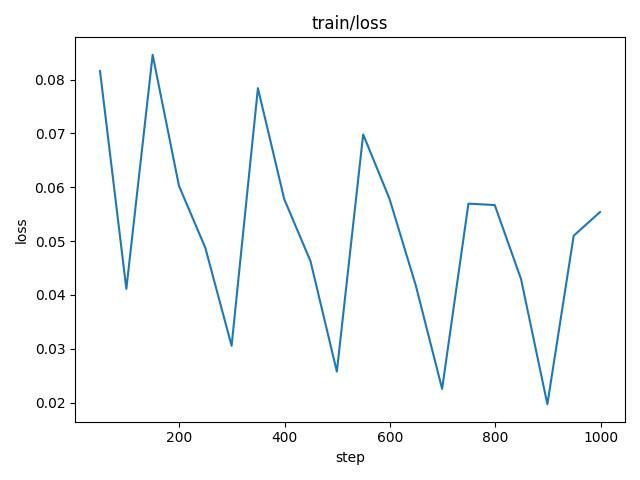

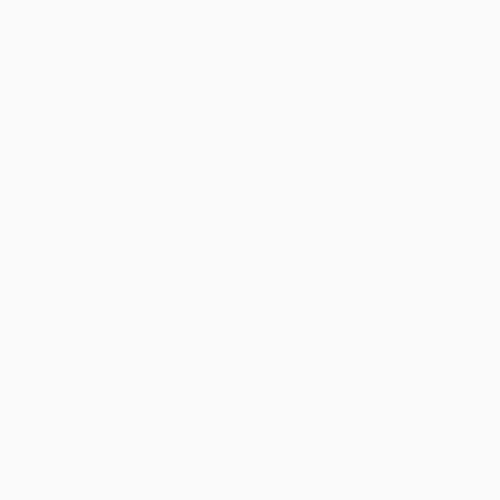


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 55.53it/s, loss=0.0517, v_num=_run]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 55.36it/s, loss=0.0517, v_num=_run]



# DVC Report

params.yaml

|   encoder_size |
|----------------|
|            128 |

metrics.json

| train                          |   epoch |   step |
|--------------------------------|---------|--------|
| {'loss': 0.054417677223682404} |       4 |    999 |

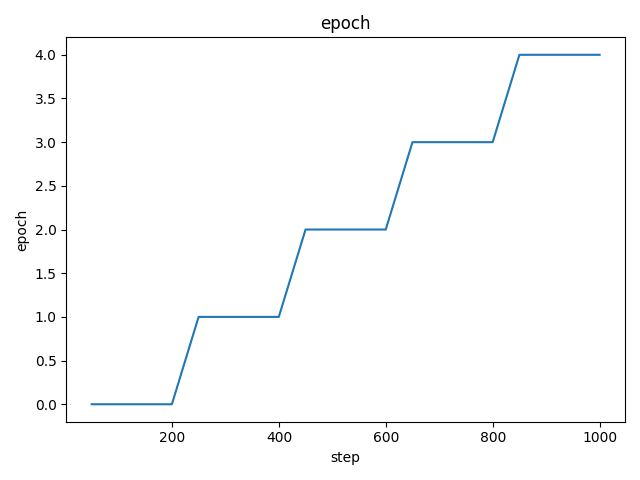

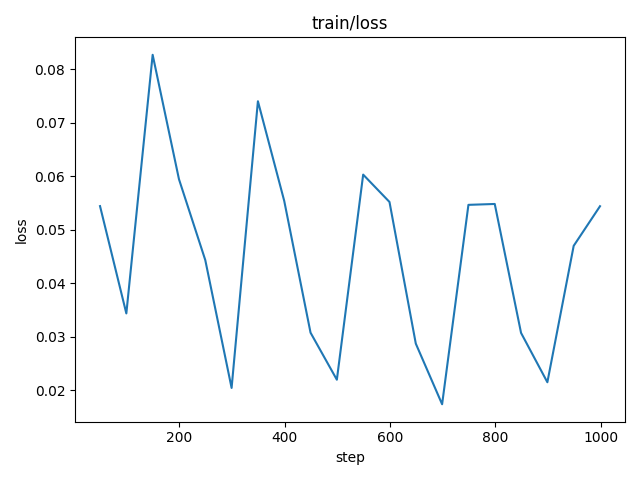

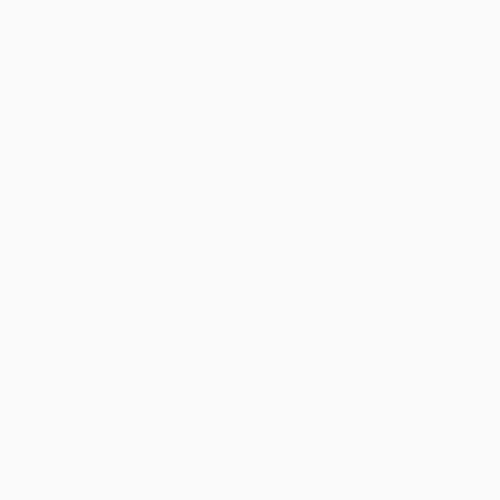


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 100 K 
1 | decoder | Sequential | 101 K 
---------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.810     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 52.77it/s, loss=0.0493, v_num=_run]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 52.64it/s, loss=0.0493, v_num=_run]



In [5]:
from PIL import Image

# train the model
for encoder_size in (32, 64, 128):
    autoencoder = LitAutoEncoder(encoder_size=encoder_size)
    with Live(save_dvc_exp=True, report="notebook") as live:
        trainer = pl.Trainer(
            limit_train_batches=200,
            max_epochs=5,
            logger=DVCLiveLogger(experiment=live)
        )
        trainer.fit(model=autoencoder, train_dataloaders=train_loader)
        img_pil = Image.new("RGB", (500, 500), (250, 250, 250))
        live.log_image("pil.jpg", img_pil)
